# Clustering Stability

In spatial transcriptomics, cells are typically clustered into cell types based on their RNA expression. If the segmentation of a spatial transcriptomics dataset went well, we would assume that this clustering is somewhat stable, even if we only cluster on parts of the data. The `cs` (clustering stability) module includes some functions to apply clustering and assess its robustness.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd
import spatialdata_plot  # noqa: F401
import squidpy as sq

import segtraq as st

# example datasets on which we can compare performance
sdata_bidcell = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/seg_comparison/spatialData_2_C1_bidcell.zarr")
sdata_segger = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/seg_comparison/spatialData_2_C1_segger.zarr")
sdata_xenium = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/seg_comparison/spatialData_2_C1_xenium.zarr")
sdata_proseg = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/seg_comparison/spatialData_2_C1_proseg.zarr")
sdata_dict = {
    "bidcell": sdata_bidcell,
    "segger": sdata_segger,
    "xenium": sdata_xenium,
    "proseg": sdata_proseg,
}

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_

## Root Mean Square Deviation (RMSD)

The root mean square deviation (RMSD) is a measure that looks at the compactness of clusters. To compute it, we first compute a PCA on the normalized and log-transformed counts, which gives us the first 50 principal components. We then run Leiden clustering on these. Finally, for each cluster, we compute the root mean square deviation of all points within the cluster from the cluster centroid. To ensure that we are not too dependent on the resolution parameter of Leiden clustering, we run it with multiple resolutions (by default 0.6, 0.8, and 1.0) and report the lowest RMSD.

In [2]:
rmsds = {}
for method, sdata in sdata_dict.items():
    rmsds[method] = st.cs.compute_rmsd(sdata)
rmsds

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


{'bidcell': 12.699893951416016,
 'segger': 3.723130941390991,
 'xenium': 3.7440602779388428,
 'proseg': 3.9636342525482178}

## Silhouette Score

A slightly more elaborate metric is the silhouette score. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Values range from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

As with the RMSD, we compute this for Leiden clustering at different resolutions and report the best one.

In [3]:
silhouette_scores = {}
for method, sdata in sdata_dict.items():
    silhouette_scores[method] = st.cs.compute_silhouette_score(sdata)
silhouette_scores

{'bidcell': 0.10390220582485199,
 'segger': 0.1020861566066742,
 'xenium': 0.09785240888595581,
 'proseg': 0.18913063406944275}

## Purity

Another way to assess cluster stability is to cluster only on a subset of all genes. For example, if we randomly select 100 genes and then perform Leiden clustering on those, will our cells typically get assigned to the same cluster or to different ones?

One way to assess this is by comparing the purity between two clusterings. For every cluster in clustering 1, we check how many other clusters it contains in clustering 2.

A purity value of 1 means that the clusters are completely pure, whereas a value closer to 0 means that they are more mixed.

We randomly select 100 genes, perform clustering on them, and do this five times, to obtain five different clusterings. Then we compare them using the purity score.

**Note:** this method will recompute the PCA based on a subset of features. If you will be using the PCA in the anndata later, you should recompute it on the whole data.

In [4]:
purities = {}
for method, sdata in sdata_dict.items():
    purities[method] = st.cs.compute_purity(sdata)
purities

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Cha

{'bidcell': 0.3335519209998457,
 'segger': 0.4426705756929638,
 'xenium': 0.42796610169491534,
 'proseg': 0.6258423122969043}

## Adjusted Rand Index (ARI)

The adjusted rand index (ARI) is another metric to determine the similarity of different clusterings (again, we create five clusterings based on random subsets of 100 genes each). Just like the purity, its values range from 0 (no similarity, not a robust clustering) to 1 (exactly the same clusters, high robustness).

In [5]:
aris = {}
for method, sdata in sdata_dict.items():
    aris[method] = st.cs.compute_ari(sdata)
aris

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Cha

{'bidcell': 0.1299466585442509,
 'segger': 0.17360159096335342,
 'xenium': 0.1558165085556677,
 'proseg': 0.41885728397994343}

## Visualization

Looking at numbers is one thing, but interpretation will be a lot easier if we visualize our results. The following couple of codeblocks demonstrate how the four methods compare.

In [6]:
# putting everything into a dataframe for easier plotting
results_df = pd.DataFrame(
    {
        "Method": list(rmsds.keys()),
        "RMSD": list(rmsds.values()),
        "Silhouette Score": list(silhouette_scores.values()),
        "Purity": list(purities.values()),
        "ARI": list(aris.values()),
    }
)

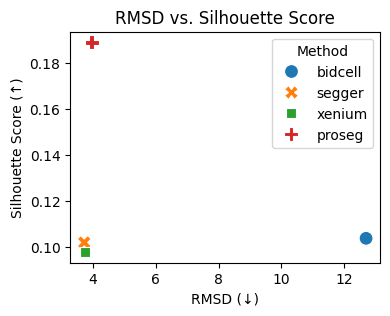

In [7]:
# plotting the RMSD vs. silhouette score
plt.figure(figsize=(4, 3))
sns.scatterplot(data=results_df, x="RMSD", y="Silhouette Score", hue="Method", style="Method", s=100)
plt.xlabel("RMSD (↓)")
plt.ylabel("Silhouette Score (↑)")
plt.title("RMSD vs. Silhouette Score")
plt.legend(title="Method")
plt.show()

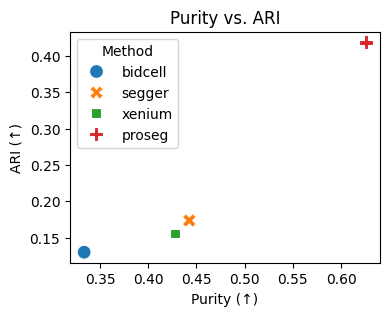

In [8]:
# plotting the purity vs. ARI
plt.figure(figsize=(4, 3))
sns.scatterplot(data=results_df, x="Purity", y="ARI", hue="Method", style="Method", s=100)
plt.xlabel("Purity (↑)")
plt.ylabel("ARI (↑)")
plt.title("Purity vs. ARI")
plt.legend(title="Method")
plt.show()

In these benchmarks, it looks pretty clear that ProSeg is the winner. But what do the segmentation masks actually look like?

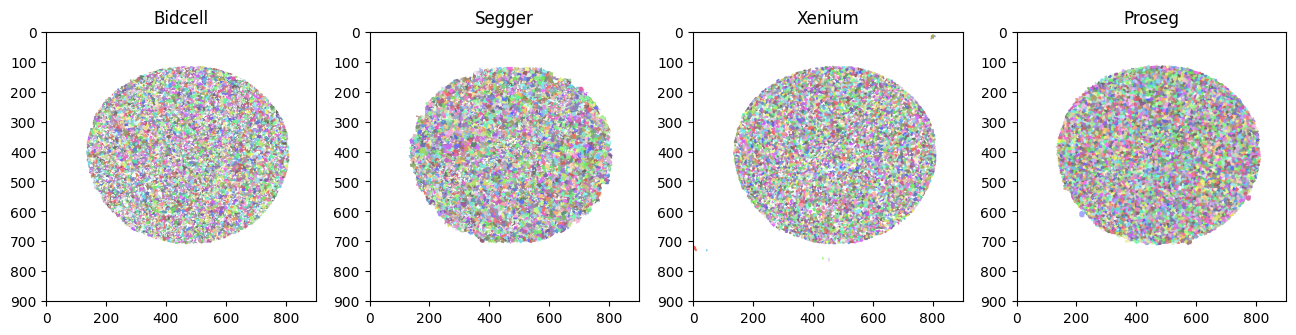

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (method, sdata) in enumerate(sdata_dict.items()):
    sdata.pl.render_labels().pl.show(ax=ax[i])
    ax[i].set_title(method.capitalize())

Let's also have a quick look at the UMAP of the cells, and go through how one could cluster them. The code for preprocessing is taken from the [squidpy documentation](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html#calculate-quality-control-metrics).

In [10]:
adata = sdata_dict["proseg"].tables["table"]
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


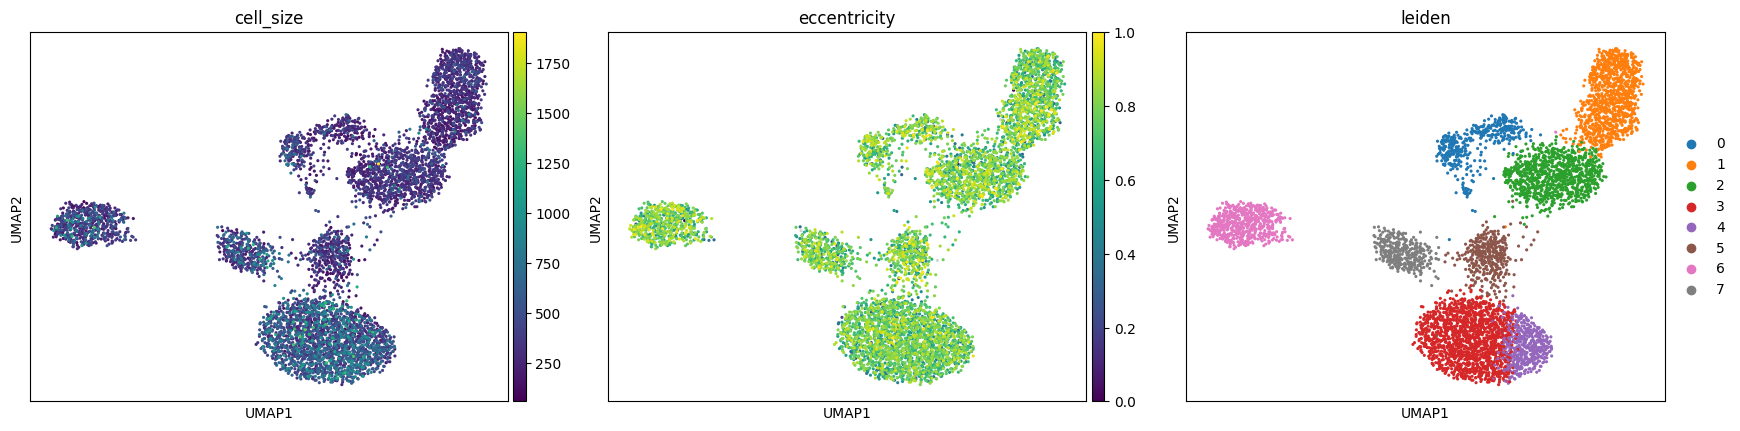

In [11]:
sc.pl.umap(
    adata,
    color=[
        "cell_size",
        "eccentricity",
        "leiden",
    ],
    wspace=0.1,
)

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


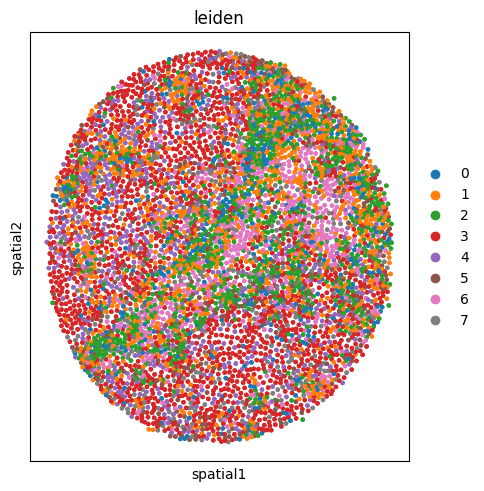

In [13]:
# we need to add the spatial coordinates to the adata object for plotting
adata.obsm["spatial"] = adata.obs[["centroid-0", "centroid-1"]].to_numpy()

sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=["leiden"],
    wspace=0.4,
)